In [ ]:
!pip install pyngrok

In [ ]:
import os
import numpy as np
import cv2
from flask import Flask, request, jsonify
from pyngrok import ngrok
import tensorflow as tf
from imutils.contours import sort_contours
import imutils

# Define the label mapping
list_label = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

# Load the trained model
model = tf.keras.models.load_model("my_model.h5")
print("Model loaded successfully")

# Initialize the Flask app
app = Flask(__name__)

@app.route("/", methods=['GET', 'POST'])
def home():
    return "Welcome to the OCR Flask App. Use the '/predict' endpoint to predict text from an image."

@app.route("/predict", methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({"error": "No image uploaded"}), 400

    # Save uploaded file
    file = request.files['image']
    filename = file.filename
    file_path = os.path.join('/tmp', filename)
    file.save(file_path)

    # Read the saved image using OpenCV
    src = cv2.imread(file_path)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)

    # Find contours of each character in the image
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    chars = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape

            if tW > tH:
                thresh = imutils.resize(thresh, width=28)
            else:
                thresh = imutils.resize(thresh, height=28)

            (tH, tW) = thresh.shape
            dX = int(max(0, 28 - tW) / 2.0)
            dY = int(max(0, 28 - tH) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX,
                                        borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
            padded = cv2.resize(padded, (28, 28))
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            chars.append((padded, (x, y, w, h)))

    if len(chars) == 0:
        return jsonify({"error": "No characters detected"}), 400

    # Process characters for prediction
    chars = np.array([c[0] for c in chars], dtype="float32")
    preds = model.predict(chars)

    output = ""
    for pred in preds:
        i = np.argmax(pred)
        label = list_label[i]
        output += label

    return jsonify({"predicted_text": output})

# Set up the ngrok tunnel
public_url = ngrok.connect(5000)
print("Public URL:", public_url)

# Run the Flask app
app.run(port=5000)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

[INFO] Loading handwriting OCR model...


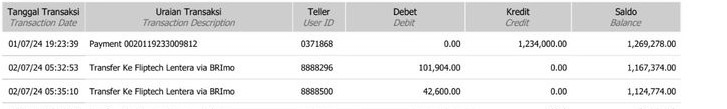

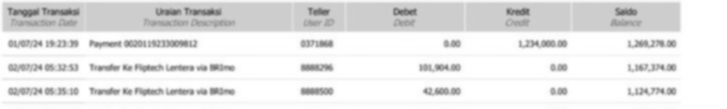

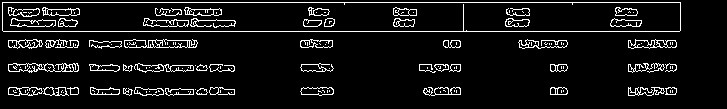

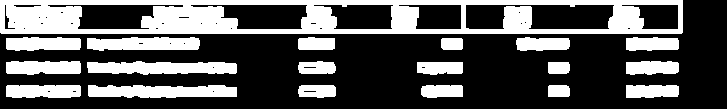

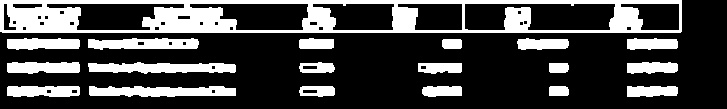

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
[INFO] m - 99.65%
[INFO] H - 68.49%
[INFO] m - 99.99%
[INFO] m - 100.00%
[INFO] m - 99.99%
[INFO] H - 65.28%
[INFO] v - 50.02%
[INFO] m - 86.54%
[INFO] m - 40.78%
[INFO] m - 95.23%
[INFO] I - 94.88%
[INFO] w - 53.91%
[INFO] v - 92.39%
[INFO] H - 46.87%
[INFO] w - 88.45%
[INFO] A - 24.47%
[INFO] m - 70.14%
[INFO] I - 52.43%
[INFO] I - 52.43%
[INFO] m - 98.15%
[INFO] m - 99.70%
[INFO] m - 99.79%
[INFO] W - 74.22%
[INFO] j - 25.62%
[INFO] I - 56.87%
[INFO] m - 76.54%
[INFO] m - 78.86%
[INFO] m - 97.69%
[INFO] I - 95.81%
[INFO] m - 99.61%
[INFO] M - 85.32%
[INFO] I - 66.25%
[INFO] W - 78.05%
[INFO] m - 99.81%
[INFO] M - 58.09%
[INFO] H - 53.44%
[INFO] H - 87.84%
[INFO] I - 53.53%
[INFO] m - 99.87%
[INFO] m - 99.89%
[INFO] I - 74.14%
[INFO] I - 66.80%
[INFO] I - 80.89%
[INFO] m - 96.30%
[INFO] m - 89.54%
[INFO] M - 40.69%
[INFO] m - 89.25%
[INFO] m - 99.74%
[INFO] I - 80.44%
[INFO] I - 86.76%
Recognized Text: mHmmmHvmmmIwvHwAmIImmmWjImmmImMIWmMHHImmIII

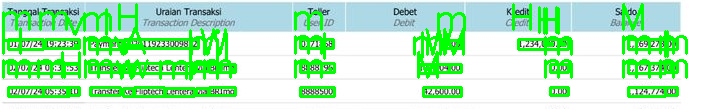

In [ ]:
# Import necessary packages
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours
import numpy as np
import imutils
import cv2

img_path = 'Mutasi-rekening-BRI.jpg'
model_path = 'my_model_1.keras'
print("[INFO] Loading handwriting OCR model...")
model = load_model(model_path)

# Define the correct label mapping
labelNames = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
labelNames = [l for l in labelNames]

# Load the input image, convert to grayscale, and blur to reduce noise
image = cv2.imread(img_path)
#image = cv2.resize(image, (100, 100))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)  # Display grayscale image for debugging

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
cv2_imshow(blurred)  # Display blurred image for debugging

# Perform edge detection
edged = cv2.Canny(blurred, 50, 100)
cv2_imshow(edged)  # Display edge-detected image for debugging

# Apply dilation and erosion to separate close contours
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edged, kernel, iterations=2)
cv2_imshow(dilated)  # Display dilated image for debugging
eroded = cv2.erode(dilated, kernel, iterations=1)
cv2_imshow(eroded)  # Display eroded image for debugging

# Find contours and sort them from left-to-right
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# print(cnts)
# Initialize the list for character bounding boxes and characters to be OCR'd
chars = []

# Loop over each contour
for c in cnts:
    # Compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # Filter out bounding boxes that are too small or too large (adjust this as needed)
    if (w >= 0  and w <= 100) and (h >= 0 and h <= 100):  # Adjusted min size
        # Extract the character ROI
        roi = gray[y:y + h, x:x + w]

        # Resize the character ROI to 28x28 while maintaining aspect ratio
        (tH, tW) = roi.shape
        if tW > tH:
            roi = imutils.resize(roi, width=28)
        else:
            roi = imutils.resize(roi, height=28)

        # Compute padding to ensure the image is 28x28
        (tH, tW) = roi.shape
        dX = (28 - tW) // 2
        dY = (28 - tH) // 2

        # Pad the image with white (255) background to make it 28x28
        padded = cv2.copyMakeBorder(roi, top=dY, bottom=dY, left=dX, right=dX,
                                    borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))

        # Ensure the final character image is 28x28
        padded = cv2.resize(padded, (28, 28))

        # Prepare the padded image for classification
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # Display each preprocessed character for debugging
        cv2_imshow((padded * 255).astype("uint8"))
        cv2.waitKey(0)

        # Update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

# Ensure there are detected characters to predict
if len(chars) == 0:
    print("[ERROR] No characters detected. Check preprocessing steps.")
else:
    # Extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)

    # Initialize a variable to hold the recognized text
    recognized_text = ""

    # Loop over predictions and bounding box locations together
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        # Find the index of the label with the largest probability
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]

        # Draw the prediction on the image
        print("[INFO] {} - {:.2f}%".format(label, prob * 100))
        recognized_text += label
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, label, (x - 10, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # Show the final annotated image with recognized text
    print("Recognized Text:", recognized_text)
    cv2_imshow(image)
    cv2.waitKey(0)


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("my_model.keras")

# Define your label mapping
list_label = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

def preprocess_image(image_path):
    # Load image and convert to grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Apply thresholding or other preprocessing
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    return thresh

def find_rois(thresh_img):
    # Find contours for text regions
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 20 and h > 20:  # Filter out small regions
            rois.append((x, y, w, h))
    rois = sorted(rois, key=lambda b: b[1])  # Sort by y-coordinate for top-to-bottom order
    return rois

def recognize_text(roi, model):
    # Resize to model input size
    roi_resized = cv2.resize(roi, (28, 28))
    roi_resized = roi_resized.reshape((1, 28, 28, 1)).astype('float32') / 255.0
    # Predict with the model
    predictions = model.predict(roi_resized)
    predicted_class = np.argmax(predictions, axis=-1)
    return list_label[predicted_class[0]]

# Process the entire document
image_path = "SMILE.png"
processed_img = preprocess_image(image_path)
rois = find_rois(processed_img)

# Recognize text in each ROI and categorize based on ROI position/order
for i, (x, y, w, h) in enumerate(rois):
    roi = processed_img[y:y+h, x:x+w]
    text = recognize_text(roi, model)
    print(f"Detected text for ROI {i}: {text}")

# Additional post-processing to structure recognized text as date, DB/KR, and amount fields

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Detected text for ROI 0: i
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Detected text for ROI 1: z
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Detected text for ROI 2: l
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Detected text for ROI 3: I


In [ ]:
# Import necessary packages
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from imutils.contours import sort_contours
import numpy as np
import imutils
import cv2

img_path = 'Mutasi.png'
model_path = 'my_model.keras'
print("[INFO] Loading handwriting OCR model...")
model = load_model(model_path)

# Define the correct label mapping
labelNames = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
labelNames = [l for l in labelNames]

# Load the input image, convert to grayscale, and blur to reduce noise
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform edge detection
edged = cv2.Canny(blurred, 30, 150)

# Apply dilation and erosion to separate close contours
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edged, kernel, iterations=2)
eroded = cv2.erode(dilated, kernel, iterations=1)

# Find contours and sort them from left-to-right
cnts = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# Initialize the list for character bounding boxes and characters to be OCR'd
chars = []

# Loop over each contour
for c in cnts:
    # Compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # Filter out bounding boxes that are too small or too large (adjust this as needed)
    if (w >= 5 and w <= 100) and (h >= 10 and h <= 100):  # Adjusted min size
        # Extract the character ROI
        roi = gray[y:y + h, x:x + w]

        # Resize the character ROI to 28x28 while maintaining aspect ratio
        (tH, tW) = roi.shape
        if tW > tH:
            roi = imutils.resize(roi, width=28)
        else:
            roi = imutils.resize(roi, height=28)

        # Compute padding to ensure the image is 28x28
        (tH, tW) = roi.shape
        dX = (28 - tW) // 2
        dY = (28 - tH) // 2

        # Pad the image with white (255) background to make it 28x28
        padded = cv2.copyMakeBorder(roi, top=dY, bottom=dY, left=dX, right=dX,
                                    borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))

        # Ensure the final character image is 28x28
        padded = cv2.resize(padded, (28, 28))

        # Prepare the padded image for classification
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)

        # Update our list of characters that will be OCR'd
        chars.append((padded, (x, y, w, h)))

# Ensure there are detected characters to predict
if len(chars) == 0:
    print("[ERROR] No characters detected. Check preprocessing steps.")
else:
    # Extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")

    # OCR the characters using our handwriting recognition model
    preds = model.predict(chars)

    # Initialize a variable to hold the recognized text
    recognized_text = ""

    # Loop over predictions and bounding box locations together
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        # Find the index of the label with the largest probability
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]

        # Append the recognized character to the recognized_text
        recognized_text += label

    # Print the final recognized text
    print("Recognized Text:", recognized_text)


[INFO] Loading handwriting OCR model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Recognized Text: nWLmmWDEoDmDmWIHoWm


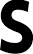

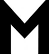

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Recognized text: KYHLE


In [ ]:
import cv2
import numpy as np

# Load the image (convert to grayscale for easier processing)
image = cv2.imread('SMILE.png', cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding to better separate characters from background
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Apply morphological operations to separate touching characters
kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation/erosion
dilated_image = cv2.dilate(thresh, kernel, iterations=1)  # Dilate
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)  # Erode

# Find contours in the eroded image (which will help us find the characters)
contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from left to right based on the x-coordinate
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

# Create a list of character images
character_images = []
for ctr in contours:
    x, y, w, h = cv2.boundingRect(ctr)

    # Ignore small contours (to avoid noise)
    if w * h > 100:  # You can adjust this threshold based on your image
        character_image = image[y:y+h, x:x+w]  # Crop out the character
        character_images.append(character_image)

# Show the segmented characters (optional, for debugging)
for char_img in character_images:
    cv2_imshow(char_img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

# Now, let's assume you have a trained model for character recognition.
# The next step would be to pass each character image to your model and recognize it.

# Initialize an empty string to store recognized text
recognized_text = ""

# Assuming your model is already loaded
for char_img in character_images:
    # Resize the character image to match the input size expected by the model (e.g., 28x28 for your model)
    char_image_resized = cv2.resize(char_img, (28, 28))

    # Normalize the image (assuming the model expects grayscale)
    char_image_resized = char_image_resized.astype('float32') / 255.0

    # Add an extra dimension to match the model's input shape (28, 28, 1)
    char_image_resized = np.expand_dims(char_image_resized, axis=-1)

    # Use your model to predict the character (assuming you have a Keras model)
    predicted_probs = model.predict(np.expand_dims(char_image_resized, axis=0))  # Shape (1, 62)
    predicted_class_idx = np.argmax(predicted_probs, axis=-1)

    # Map the predicted index to the character
    list_label = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    predicted_char = list_label[predicted_class_idx[0]]
    recognized_text += predicted_char  # Append the recognized character

# Display the recognized text
print("Recognized text:", recognized_text)
